<a href="https://colab.research.google.com/github/modobasic/Racunalni-vid---projekt/blob/main/Multiscale_Morphological_Gland_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/modobasic/Racunalni-vid---projekt/blob/main/Multiscale_Morphological_Gland_Segmentation.ipynb)

In [ ]:
!mkdir -p data
!unzip archive.zip -d data
!ls data



Archive:  archive.zip
replace data/Warwick_QU_Dataset/Grade.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Warwick_QU_Dataset


In [ ]:
import os, glob, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

DATA_DIR = "data/Warwick_QU_Dataset"

def find_pairs(folder):
    files = glob.glob(folder + "/*.bmp")
    images = [f for f in files if not f.endswith("_anno.bmp")]
    pairs = []
    for img in images:
        mask = img.replace(".bmp", "_anno.bmp")
        if os.path.exists(mask):
            pairs.append((img, mask))
    return sorted(pairs)

pairs = find_pairs(DATA_DIR)
print("Broj parova (slika+maska):", len(pairs))
print("Primjer:", os.path.basename(pairs[0][0]), "|", os.path.basename(pairs[0][1]))


Broj parova (slika+maska): 165
Primjer: testA_1.bmp | testA_1_anno.bmp


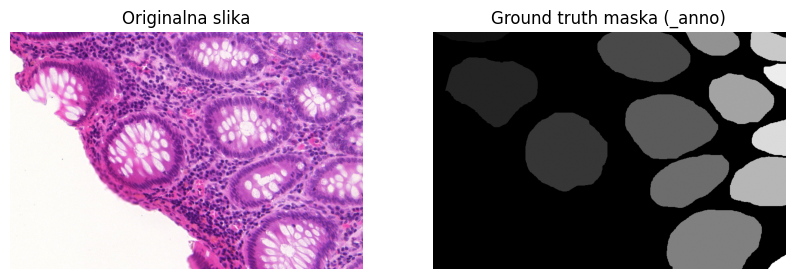

Odabrano: train_85.bmp


In [ ]:
img_path, mask_path = random.choice(pairs)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Originalna slika")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground truth maska (_anno)")
plt.axis("off")
plt.show()

print("Odabrano:", os.path.basename(img_path))


In [ ]:
def preprocess(img):
    # HSV -> uzmi V kanal (svjetlina), često bolje za lumen žlijezda
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    blur = cv2.GaussianBlur(v, (7,7), 0)

    # Morfološko zatvaranje prije praga (spaja fragmente u kompaktnije regije)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    closed = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, k)

    # Otsu prag
    _, binary = cv2.threshold(closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # želimo da žlijezde budu bijele (ako ispadne suprotno, invert)
    if np.mean(binary) < 127:
        binary = cv2.bitwise_not(binary)

    # dodatno smanji sol-i-papar šum
    binary = cv2.medianBlur(binary, 5)

    return binary


In [ ]:
def multiscale(binary, scales=(7, 15, 25)):
    combined = np.zeros_like(binary)
    results = {}

    for s in scales:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (s, s))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

        results[s] = closed
        combined = cv2.bitwise_or(combined, closed)

    return combined, results


In [ ]:
def postprocess(mask, min_area=100, remove_biggest=True, biggest_ratio=0.60):
    """
    mask: 0/255 ili 0/1 ili bilo što >0 kao foreground
    min_area: minimalna površina objekta koji ostaje
    remove_biggest: ukloni najveću komponentu samo ako izgleda kao pozadina/artefakt
    biggest_ratio: prag (0-1). Ako najveća komponenta zauzima > biggest_ratio slike, tretiramo je kao pozadinu.
    """
    m = (mask > 0).astype(np.uint8) * 255

    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        return m

    areas = stats[1:, cv2.CC_STAT_AREA]  # bez pozadine
    biggest_idx = 1 + np.argmax(areas)

    h, w = m.shape
    img_area = h * w
    biggest_area = stats[biggest_idx, cv2.CC_STAT_AREA]

    out = np.zeros_like(m)

    for i in range(1, num):
        area = stats[i, cv2.CC_STAT_AREA]

        # Ukloni najveću komponentu samo ako je "prevelika" (tipično pozadina ili spojeni artefakt)
        if remove_biggest and i == biggest_idx and (biggest_area / img_area) > biggest_ratio:
            continue

        if area >= min_area:
            out[labels == i] = 255

    # ---- Fill holes SIGURNO ----
    # Napravimo flood fill pozadine na invertiranom, pa izdvojimo rupe
    inv = cv2.bitwise_not(out)  # rupe postaju bijele, pozadina bijela, objekti crni
    ff = inv.copy()
    ff_mask = np.zeros((h+2, w+2), np.uint8)

    # Flood fill "prave pozadine" (iz kuta) u crno (0)
    cv2.floodFill(ff, ff_mask, (0, 0), 0)

    # Sve što je ostalo bijelo u ff su rupe (nisu povezane s rubom)
    holes = (ff == 255).astype(np.uint8) * 255

    filled = cv2.bitwise_or(out, holes)

    return filled


Skale u per_scale: [7, 15, 25]


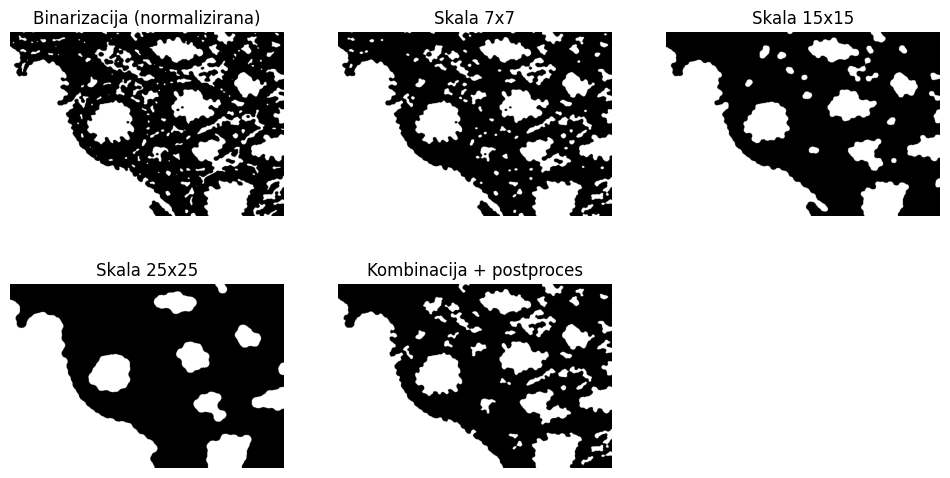

In [ ]:
img = cv2.imread(img_path)
binary = preprocess(img)

# 1) NORMALIZACIJA: želimo da žlijezde budu BIJELE, pozadina CRNA
# Ako je većina bijela, znači da je pozadina bijela -> invertiraj
if np.mean(binary) > 127:
    binary = cv2.bitwise_not(binary)

# (opcionalno, ali često korisno) smanji sitni šum
binary = cv2.medianBlur(binary, 5)

# 2) Višeskalna morfologija
final_mask, per_scale = multiscale(binary, (7, 15, 25))
print("Skale u per_scale:", sorted(per_scale.keys()))

# 3) Postproces
# Sad remove_biggest može ostati True jer smo standardizirali prednji plan
final_mask_pp = postprocess(final_mask, min_area=150, remove_biggest=True, biggest_ratio=0.60)



# 4) Prikaz (sortirano po skali da bude uvijek 7,15,25)
plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.imshow(binary, cmap="gray")
plt.title("Binarizacija (normalizirana)")
plt.axis("off")

i = 2
for s in sorted(per_scale):
    plt.subplot(2,3,i)
    plt.imshow(per_scale[s], cmap="gray")
    plt.title(f"Skala {s}x{s}")
    plt.axis("off")
    i += 1

plt.subplot(2,3,i)
plt.imshow(final_mask_pp, cmap="gray")
plt.title("Kombinacija + postproces")
plt.axis("off")

plt.show()


In [ ]:
def iou(pred, gt):
    pred = pred > 0
    gt = gt > 0
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return inter / union if union > 0 else 1.0

def dice(pred, gt):
    pred = pred > 0
    gt = gt > 0
    inter = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    return (2 * inter / denom) if denom > 0 else 1.0

def precision_recall(pred, gt):
    pred = pred > 0
    gt = gt > 0

    tp = np.logical_and(pred, gt).sum()
    fp = np.logical_and(pred, np.logical_not(gt)).sum()
    fn = np.logical_and(np.logical_not(pred), gt).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 1.0
    return precision, recall


In [ ]:
configs = [
    (7,),
    (15,),
    (25,),
    (7, 15, 25)
]

sample = random.sample(pairs, min(50, len(pairs)))

for scales in configs:
    ious, dices, pres, recs = [], [], [], []

    for img_path, mask_path in sample:
        img = cv2.imread(img_path)
        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        binary = preprocess(img)
        pred, _ = multiscale(binary, scales)

        pred = postprocess(pred, min_area=100, remove_biggest=True)

        ious.append(iou(pred, gt))
        dices.append(dice(pred, gt))
        p, r = precision_recall(pred, gt)
        pres.append(p); recs.append(r)

    print("Skale:", scales)
    print("IoU    mean±std:", round(np.mean(ious),3), "±", round(np.std(ious),3))
    print("Dice   mean±std:", round(np.mean(dices),3), "±", round(np.std(dices),3))
    print("Prec.  mean±std:", round(np.mean(pres),3), "±", round(np.std(pres),3))
    print("Recall mean±std:", round(np.mean(recs),3), "±", round(np.std(recs),3))
    print("-"*40)


Skale: (7,)
IoU    mean±std: 0.458 ± 0.212
Dice   mean±std: 0.595 ± 0.227
Prec.  mean±std: 0.548 ± 0.196
Recall mean±std: 0.825 ± 0.312
----------------------------------------
Skale: (15,)
IoU    mean±std: 0.444 ± 0.202
Dice   mean±std: 0.586 ± 0.211
Prec.  mean±std: 0.553 ± 0.206
Recall mean±std: 0.791 ± 0.315
----------------------------------------
Skale: (25,)
IoU    mean±std: 0.448 ± 0.206
Dice   mean±std: 0.588 ± 0.213
Prec.  mean±std: 0.552 ± 0.206
Recall mean±std: 0.793 ± 0.294
----------------------------------------
Skale: (7, 15, 25)
IoU    mean±std: 0.348 ± 0.26
Dice   mean±std: 0.458 ± 0.308
Prec.  mean±std: 0.537 ± 0.238
Recall mean±std: 0.629 ± 0.444
----------------------------------------
